In [1]:
from aux_functions import *

In [2]:
video_path = "/Users/diegosilveracoeff/Downloads/Video_Rami.mp4"
frame_nums = [32, 33]  # Números de frames que deseas extraer
output_folder = "/Users/diegosilveracoeff/Desktop/Fing/DCM"

extract_frames(video_path, frame_nums, output_folder)

Frame 32 guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/frame_32.png
Frame 33 guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/frame_33.png


In [2]:
# reference_frame_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_32.png'
# current_frame_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_33.png'
# output_path = "/Users/diegosilveracoeff/Desktop/Fing/DCM/substract_frames_clip.png"

reference_frame_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCM_reference_image.png'
current_frame_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCM_7x7_image.png'
output_path = "/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/residual_image.png"

subtract_frames(current_frame_path, reference_frame_path, output_path, clip=True)

Valor mínimo de diferencia:  -255
Valor máximo de diferencia:  255
Resultado de la resta ajustado y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/residual_image.png


(32, 32, 2)
flow_x guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/flow_x.npy
flow_y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/flow_y.npy
Visualización del flujo óptico guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/optical_flow_visualization.png


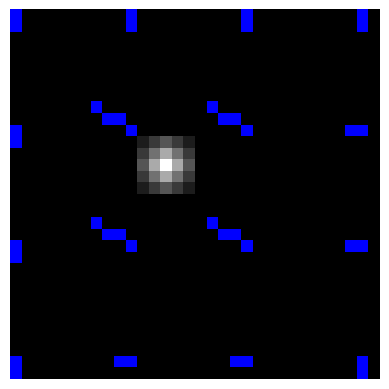

In [3]:
output_folder = "/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian"

optical_flow(current_frame_path, reference_frame_path, output_folder)

In [4]:
flow_x_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/flow_x.npy'
flow_y_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/flow_y.npy'
output_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/motion_corrected_frame_npwhere_reference_based.png'

encoder_motion_correction(current_frame_path, reference_frame_path, flow_x_path, flow_y_path, output_path)

Current frame con motion correction guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/motion_corrected_frame_npwhere_reference_based.png


In [5]:
corrected_current_frame = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/motion_corrected_frame_npwhere_reference_based.png'
output_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/motion_corrected_difference.png'
subtract_frames(corrected_current_frame, reference_frame_path, output_path, clip=True)

Valor mínimo de diferencia:  0
Valor máximo de diferencia:  0
Resultado de la resta ajustado y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/motion_corrected_difference.png


In [6]:
diff_original = cv2.imread('/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/residual_image.png')
diff_corrected = cv2.imread('/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/motion_corrected_difference.png')

energy_diff_original = np.sum(np.abs(diff_original-128))
energy_diff_corrected = np.sum(np.abs(diff_corrected-128))

print(energy_diff_original)
print(energy_diff_corrected)

16881
0


In [2]:
# Pruebo la codificación con la imagen de referencia 
reference_frame_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCM_reference_image.png'
counted_pixels = count_pixel_values(reference_frame_path)
print(counted_pixels)
symbols, codes = huffman_codebook(counted_pixels)
print(symbols, codes)
write_encoded_file(reference_frame_path, symbols, codes, '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/Encoded_reference_image.bin')

(32, 32)
[('0', 999), ('28', 4), ('57', 8), ('85', 4), ('113', 4), ('170', 4), ('255', 1)]
Símbolo: 0, Código Huffman: 1
Símbolo: 28, Código Huffman: 0101
Símbolo: 57, Código Huffman: 011
Símbolo: 85, Código Huffman: 000
Símbolo: 113, Código Huffman: 0100
Símbolo: 170, Código Huffman: 0011
Símbolo: 255, Código Huffman: 0010
[  0  28  57  85 113 170 255] ['1' '0101' '011' '000' '0100' '0011' '0010']
(32, 32)
Largo de la imagen codificada (mensaje) 1087
Fillout_number:  1
000000010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010101100001101011111111111111111111111111110110100001

Cadena binaria: 000000010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010101100001101011111111111111111111111111110110100001101000111111111111111111111111111110000011001000110001111111111111111111111111110110100001101000111111111111111111111111111110101011000011010111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

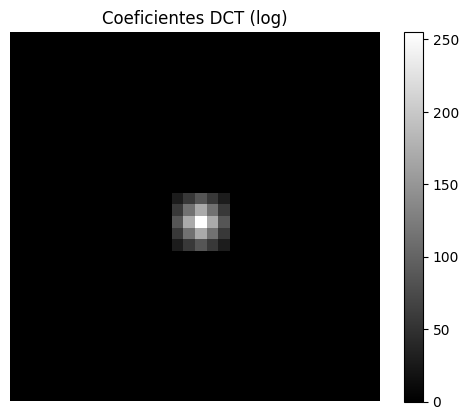

In [5]:
message = read_bin_file('/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/Encoded_reference_image.bin')
print(type(message))
decoded_file = decode_symbols(message, symbols, codes, np.array([32,32]))
plt.imshow(decoded_file, cmap='gray', vmin=0, vmax=np.max(decoded_file))
plt.colorbar()
plt.title('Coeficientes DCT (log)')
plt.axis('off')  # Ocultar ejes
plt.show()